In [1]:
import pandas as pd
import numpy as np

In [13]:
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/drive/MyDrive/datasets/GOOG.csv')

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...,...
4870,2023-12-22,142.130005,143.250000,142.054993,142.720001,142.720001,18494700
4871,2023-12-26,142.979996,143.945007,142.500000,142.820007,142.820007,11170100
4872,2023-12-27,142.830002,143.320007,141.050995,141.440002,141.440002,17288400
4873,2023-12-28,141.850006,142.270004,140.828003,141.279999,141.279999,12192500


In [4]:
df = df[['Date', 'Close']]

In [5]:
df['Date']

0       2004-08-19
1       2004-08-20
2       2004-08-23
3       2004-08-24
4       2004-08-25
           ...    
4870    2023-12-22
4871    2023-12-26
4872    2023-12-27
4873    2023-12-28
4874    2023-12-29
Name: Date, Length: 4875, dtype: object

In [6]:
import datetime

In [7]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [8]:
str_to_datetime('1999-06-06')

datetime.datetime(1999, 6, 6, 0, 0)

In [9]:
df['Date'] = df['Date'].apply(str_to_datetime)

<ipython-input-9-82fc7f804c29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


In [10]:
df

,Date,Close
0,2004-08-19,2.499133
1,2004-08-20,2.697639
2,2004-08-23,2.724787
3,2004-08-24,2.611960
4,2004-08-25,2.640104
...,...,...
4870,2023-12-22,142.720001
4871,2023-12-26,142.820007
4872,2023-12-27,141.440002
4873,2023-12-28,141.279999


In [11]:
df.index = df.pop('Date')

In [12]:
df

,Close
Date,
2004-08-19,2.499133
2004-08-20,2.697639
2004-08-23,2.724787
2004-08-24,2.611960
2004-08-25,2.640104
...,...
2023-12-22,142.720001
2023-12-26,142.820007
2023-12-27,141.440002


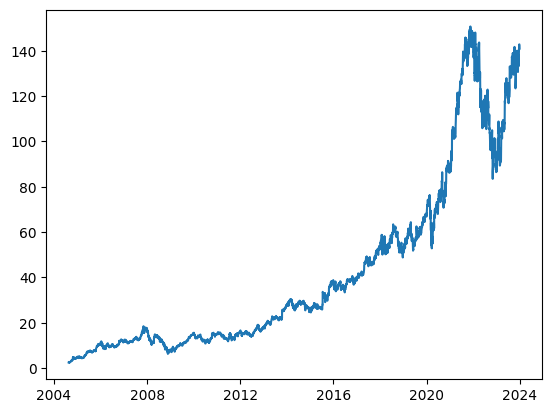

In [14]:
plt.plot(df.index, df['Close'])

As we are using LSTM we need to convert it to supervised learning

In [15]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

In [19]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((503,), (503, 3, 1), (503,))

((503,), (503, 3, 1), (503,))

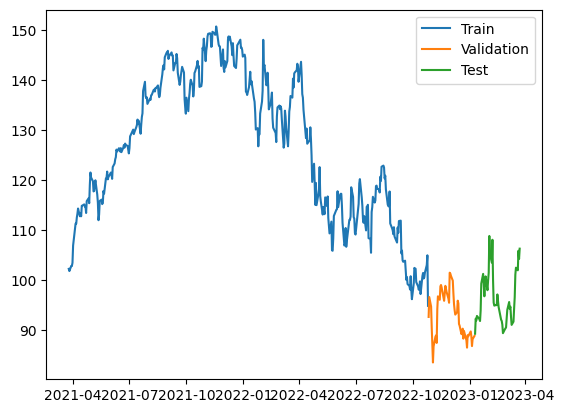

In [21]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
13/13 [==============================] - 5s 87ms/step - loss: 16113.0059 - mean_absolute_error: 126.0943 - val_loss: 8522.8066 - val_mean_absolute_error: 92.2029
Epoch 2/100
13/13 [==============================] - 0s 12ms/step - loss: 15889.4092 - mean_absolute_error: 125.2001 - val_loss: 8344.9736 - val_mean_absolute_error: 91.2334
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 15591.1631 - mean_absolute_error: 124.0050 - val_loss: 8078.4551 - val_mean_absolute_error: 89.7607
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 15164.6270 - mean_absolute_error: 122.2657 - val_loss: 7663.9258 - val_mean_absolute_error: 87.4204
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 14467.2324 - mean_absolute_error: 119.3757 - val_loss: 6995.4829 - val_mean_absolute_error: 83.5097
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 13353.9990 - mean_absolute_error: 114.5921 - val_loss: 5977

13/13 [==============================] - 1s 3ms/step


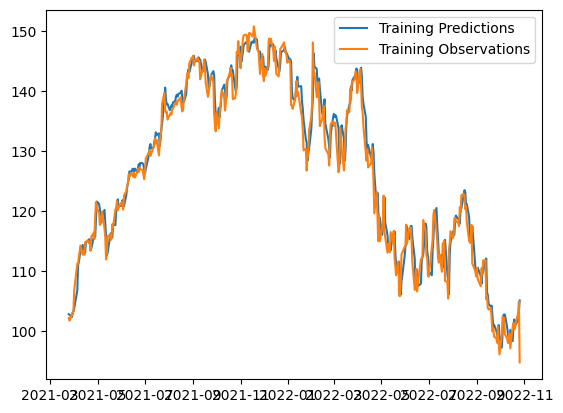

In [23]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 6ms/step


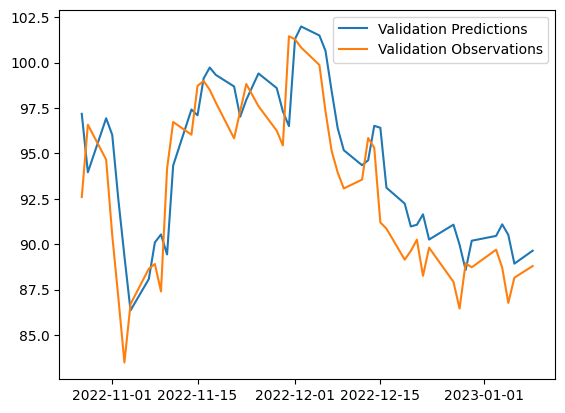

In [24]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 7ms/step


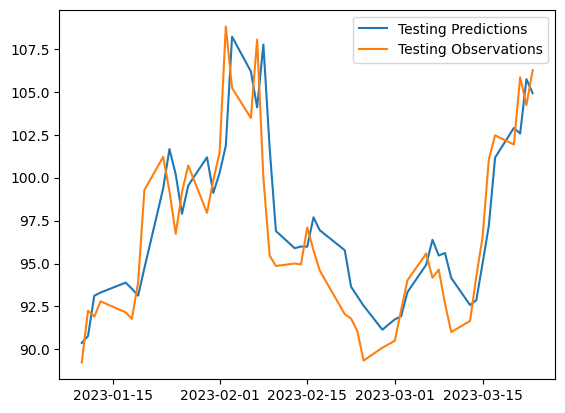

In [25]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

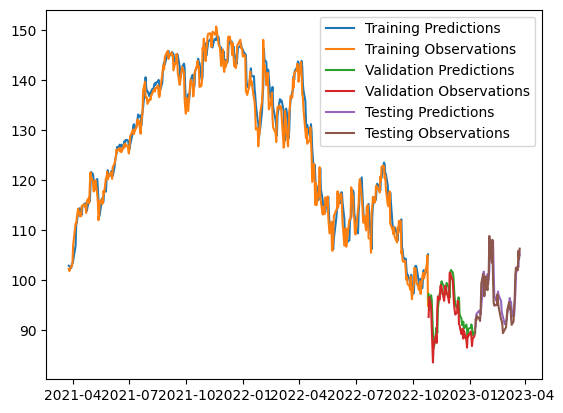

In [26]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [27]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 22ms/step


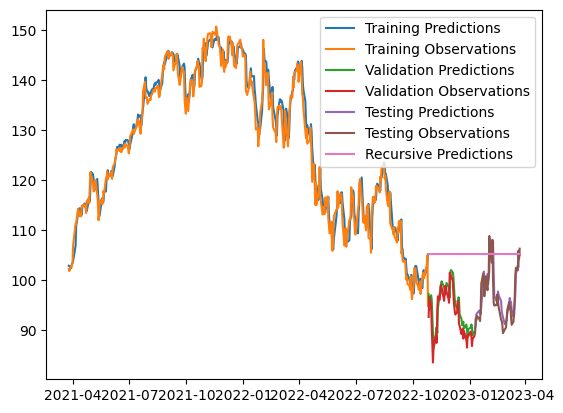

In [28]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])